# Enhanced spatio-temporal electric load forecasts with less data using active deep learning
---


## Content overview 

1. Data processing
2. Prediction model
3. Active learning


Given the aerial image of a building, the meteorological conditions in the region of that building and a time stamp, we want to predict the electric load profile of the building for the next 24 hours in 15 min steps. We start with a prediction model that has learnt this relationship for a few buildings and times. Our features are all remotely sensed and available for every building and point in time at no cost. For every new load profile that we collect, we experience some cost and are constrained in the total number of profiles that we can collect by some budget. Our goal is to collect further ground truth data, i.e. the electric load profiles at different times and buildings, so as to make the best possible predictions for buildings and times, for which we do not have load profiles available, without exceeding our data budget. 

In each iteration of the AL algorithm that we apply, we query a batch of candidate data points. First, we encode the features of candidate data points into an embedded vector space using a modular neural network prediction model that is trained on initially available data points. We then cluster candidate data points based on their vector distances to each other in this encoded space, with the number of clusters being equal to our query batch size. Next, we calculate the distance of the vector of each encoded data point to its cluster center, and query one data point per cluster based on these distances. We test our AL method for randomized, maximized, minimized and averaged distances in every queried data batch. We refer to these as our query variants.

<img src="../images/rm_QueryVariants.pdf">

The figure above visualizes the different variants of embedding distance based data queries. In a first variant of our AL method, we randomly select data points from each embedded cluster of candidates (rnd d_c). In a second variant, we query candidate data points whose embedded feature vectors are further away from their cluster centers (max d_c). We expect to be more uncertain about these points, as they are more likely to be true members of another cluster: we likely explore the data that is close to our decision boundaries, if not outliers, and expect a larger surprise/learning experience from querying labels for these data points. In a third variant, we query labels of data points that are close to their cluster centers, which we expect to be more representative of their clusters and respectively our entire data population (min d_c). In a fourth variant, we query data points that have the largest distance to the average of distances to cluster centers among all points of the same cluster, which results in a combination of queries alternating between uncertain and representative data points (avg d_c).

<img src="../images/manuscript/Appendix2.pdf">

The figure above visulizes the concept of embedding networks and the type of data that is encoded in the given prediction task. The abbreviation ANN stands for a densely connected, CNN for a convolutional, RNN for a recurrent and CRNN for a convolutional and recurrent neural network architecture. The scatter plots represent the candidate data points that are encoded using one of the encoders from the embedding network exemplarly for a queried batch size of three and embedded feature vectors of dimension two. Points of the same color are equally clustered. Squares represent cluster centers. Crosses describe which data points are chosen when randomizing (rnd d_c), maximizing (max d_c), minimizing (min d_c) and averaging (avg d_c - only one marked point per cluster is chosen) the embedding distance of a queried data batch. 

---

## Citations

For citations and more background on this work, refer to: **Aryandoust, A., Pfenninger, S. Active machine learning for spatio-temporal predictions. Preprint at https://arxiv.org/abs/2012.04407 (2020).**

---

## File overview

* src: folder containing the source code for jupyter notebooks and python scripts
* data: folder containing required data for running experiments 
* results: folder containing results after running experiments
* images: folder containing images for this readme and manuscript
* Docker: repository containing a Dockerfile for running hypothesis test inside a docker container
* DockerNotebook: repository containing a Dockerfile for running notebooks inside a docker container
* DockerUnittests: repository containing a Dockerfile for running unit tests inside a docker container
* src/main.py: main file for reproducing experimental results
* src/hyperparameters.py: module for choosing all hyper parameters of experiments
* src/data.py: module for processing data 
* src/prediction.py: module for building, training and testing prediction models
* src/activelearning.py: active learning methods
* src/main_notebook.ipynb: Jupyter notebook session for reproducing method and experiments
* src/results_notebook.ipynb: Jupyer notebook sessions for plotting and analysing experimental results
* tests/test_prediction.py: unit tests for prediction.py
* tests/test_activelearning.py: unit tests for activelearning.py
---

## Docker 

Download this repository to your home directory. With your current working directory being this repository, run:

`docker build -t main Docker`

For CPU computation, run:

`docker run -v ~/DataSelectionMaps:/DataSelectionMaps main`

For GPU support, make sure you have the nvidia-container-toolkit installed, then run:

`docker run --gpus all -v ~/DataSelectionMaps:/DataSelectionMaps main`

**Note:** If you download this repository to a location other than your home directory, make sure it is at a sub-directory of your home directory and replace all ~/ActiveLearning with ~/path/to/subdirectory/ActiveLearning in the commands, i.e.

`docker run -v ~/path/to/subdirectory/DataSelectionMaps:/DataSelectionMaps main`


`docker run --gpus all -v ~/path/to/subdirectory/DataSelectionMaps:/DataSelectionMaps main`

---

## Jupyter notebooks with docker

For running jupyter notebook sessions inside a docker container, run:

`docker build -t main_notebook DockerNotebook`

For CPU computation, run:

`docker run -it -v ~/DataSelectionMaps:/DataSelectionMaps -p 3333:1111 main_notebook`

For GPU support, make sure you have the nvidia-container-toolkit installed, and run:

`docker run -it --gpus all -v ~/DataSelectionMaps:/DataSelectionMaps -p 3333:1111 main_notebook`

Next, open localhost:3333 in your browser and type in the token from your terminal as password to run Jupyter notebook sessions inside the docker container from your browser.

**Note:** If you download this repository to a location other than your home directory, make sure it is at a sub-directory of your home directory and replace all ~/ActiveLearning with ~/path/to/subdirectory/ActiveLearning in the commands, i.e.

`docker run -it -v ~/path/to/subdirectory/DataSelectionMaps:/DataSelectionMaps -p 3333:1111 main_notebook`


`docker run -it --gpus all -v ~/path/to/subdirectory/DataSelectionMaps:/DataSelectionMaps -p 3333:1111 main_notebook`

---

## Unit tests with docker

For running unittests for the implemented active learning algorithm inside a docker container, run:

`docker build -t tests DockerUnittests`

For CPU computation, run:

`docker run -v ~/DataSelectionMaps:/DataSelectionMaps tests`

For GPU support, make sure you have the nvidia-container-toolkit installed, then run:

`docker run --gpus all -v ~/DataSelectionMaps:/DataSelectionMaps tests`

**Note:** If you download this repository to a location other than your home directory, make sure it is at a sub-directory of your home directory and replace all ~/ActiveLearning with ~/path/to/subdirectory/ActiveLearning in the commands, i.e.

`docker run -v ~/path/to/subdirectory/DataSelectionMaps:/DataSelectionMaps tests`


`docker run --gpus all -v ~/path/to/subdirectory/DataSelectionMaps:/DataSelectionMaps tests`

---

We start with importing a number of packages that we need for implementing this algorithm, and define a number of hyper parameters that are bundled through the use of attributes of a class object *HyperParameter* defined in **hyperparameters.py**.

In [1]:
### Package imports and computation environment setup ###

import gc
import os
import random
import math
import numpy as np

# decide which GPU(s) should be seen by CUDA before importing tf.
# Choose '-1' for calculation on CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf

# tell us how many GPUS are visible to CUDA and tensorflow
print(
    'Num GPUs Available: ', 
    len(tf.config.experimental.list_physical_devices('GPU'))
)

# Import application source code
import hyperparameters
import data
import prediction
import activelearning


# Set a randomization seed for better reproducability of results,
# or None for avoiding any possible effect on experiments
seed = 3

if seed is not None:

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Set seed for tf weight initialzers
    random_normal = tf.keras.initializers.RandomNormal(
        mean=0.0, 
        stddev=0.05, 
        seed=seed
    )
    random_uniform = tf.keras.initializers.RandomUniform(
        minval=-0.05, 
        maxval=0.05, 
        seed=seed
    )
    truncated_normal = tf.keras.initializers.TruncatedNormal(
        mean=0.0, 
        stddev=0.05, 
        seed=seed
    )
    glorot_normal = tf.keras.initializers.GlorotNormal(
        seed=seed
    )
    glorot_uniform = tf.keras.initializers.GlorotUniform(
        seed=seed
    )
    orthogonal = tf.keras.initializers.Orthogonal(
        gain=1.0, 
        seed=seed
    )
    variance_scaling = tf.keras.initializers.VarianceScaling(
                       scale=1.0, 
                       mode='fan_in', 
                       distribution='truncated_normal', 
                       seed=seed
    )

# class instance that contains all our hyperparameters
HYPER = hyperparameters.HyperParameter(random_seed=seed)

Num GPUs Available:  0

 You run in public access mode, and only have access to public data. HYPER.LABELS is set to "feature_scaled".


## 1 Data processing

In this section, we create training, validation and testing datasets which are ready to be processed by the deep learning models that we will create in the next section. First, we import our underlying label and feature data. Our labels are building-scale electric consumption profiles. Our features are high resolution aerial images of these buildings and the meteorlogical conditions at these buildings. Next, we build feature label pairs from these raw data and further add the time stamps at which electric consumption values are measured as another feature to each of our data points. We then proceed with normalizing our data, splitting it for training, validation and testing, and eventually standardizing all datasets with the statistics (mean and standard deviation of features) of the training data. 

We start with creating two new class objects: first, *RawData*, which we use to bundle paths to where our data is stored and miscellaneous other useful values; second, *Dataset*, which we use to bundle vectors of time variant (X_t), space variant (X_s, X_s1) and space-time variant (X_st) features, as well as their corresponding labels (Y). Classes and functions that we introduce in this section are defined in **data.py**.

In [2]:
raw_data = data.RawData(HYPER)

### 1.1 Building-scale electric consumption profiles

The electric consumption profiles that we use are measured in 15-min time steps. Each day hence has 96 values. Each year respectively has 35,040 values. The profiles are mostly added up from single sub profiles, so as to eventually represent the total consumption of the corresponding building, and not only of distinct entities inside each building, such as several apartments inside the same building. Each building and its corresponding load profile is identified through a building ID, a cluster ID and a year ID which we import and save separately for all of these profiles. The plots below show the profiles of exmeplar buildings. The x-axes represent the time stamp in which the electric consumption is measured, and the y-axes the electric power consumption in kilo Watt (hours) [kW/kWh]. 

Importing consumption profiles
1/1 [==============================] - 3s 3s/step
The 451 imported electric load profiles demand a total amount of 0.12670464 GB of RAM


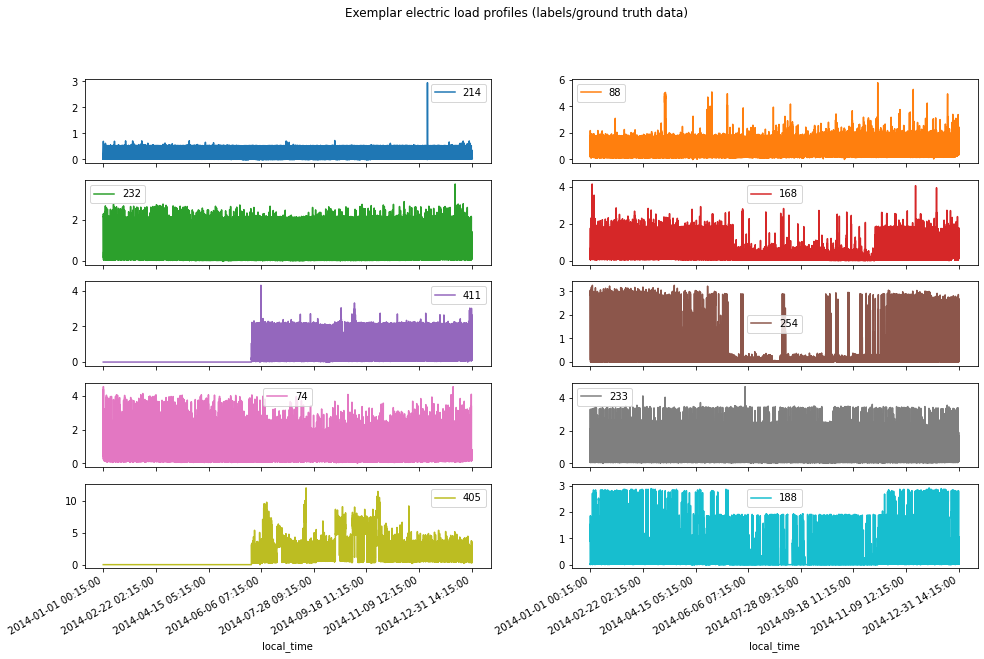

In [3]:
raw_data = data.import_consumption_profiles(HYPER, raw_data)

### 1.2 Building-scale aerial imagery

For each building whose electric consumption profile we loaded, we further import an aerial image that is cropped to an excerpt from that building only. Images are padded with zero values (black) on their empty borders so as to all have the same size. Here, we also perform the optional down sampling and grey scaling of images. For each imported building image, we further keep track of their corresponding building IDs so as to be able to assign these to each other during further data processing or during training, validation and testing of our prediction model.

In [4]:
raw_data = data.import_building_images(HYPER, raw_data)

Importing building-scale aerial imagery:
451/451 [==============================] - 0s 37us/step
The 451 aerial images demand 0.0010823999999999931 GB RAM with float32 entries


### 1.3 Cluster-scale meteorological data

Buildings that are in a maximum distance of one kilo meter (km) to each other belong to the same cluster. Instead of using meteorological data for each individual building, we use meteorological data for each cluster. This significantly reduces our data demand for meteorological data without any relevant loss of accuracy. Here, we import the meteorological data for each cluster and keep track of the cluster IDs for each imported dataset. The resolution of these measurements is hourly. The number of past data points that we use for each data point is determined through hyper parameters. The plot below shows all meteorological conditions that we import and consider as features for an exemplar cluster ID. These are air density, cloud cover, precipitation, solar irradiance on the surface, solar irradiance on the atmosphere, snow mass, snowfall, temperature and wind speed. The x-axes represents the time stamp in which the meteorological conditions are measured, and the y-axes the respective values in their various respective units. These values consist of air density in kg/m³, cloud cover, precipitation in mm/hour, ground level solar irradiance in W/m², top of atmosphere solar irradiance W/m², air temperature in °C, snowfall in mm/hour, snow mass in kg/m² and wind speed.

Importing meteorological data
91/91 [==============================] - 4s 44ms/step
The 91 meteo data files demand 0.25509120000000035 GB RAM


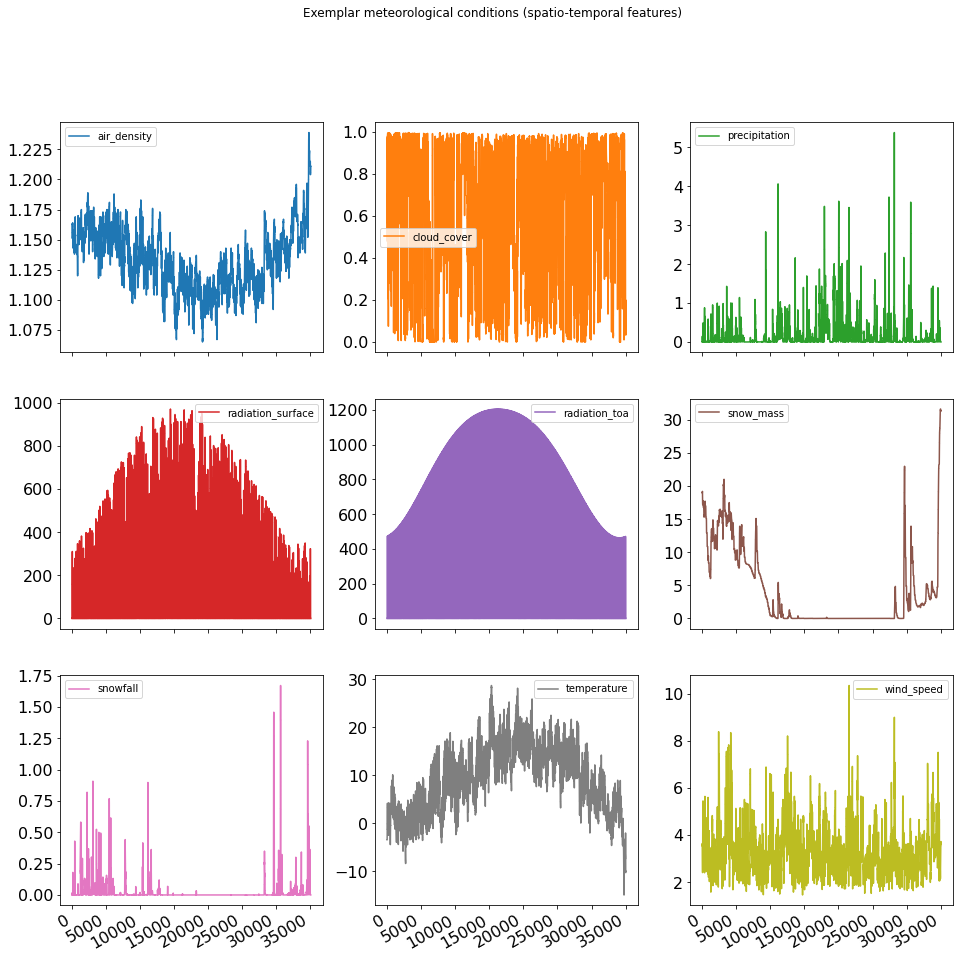

In [5]:
raw_data = data.import_meteo_data(HYPER, raw_data)

### 1.4 Feature-label pairing

For each time stamp in which electric consumption and meteorological measurements match, and for each building, we create a unique data point consisting of features and labels. Here, we further add the time stamp distinguished by the year, month, day, hour and quarter hour as a feature to each data point. Therefore, each data point consists of a time variant feature vector X_t (time stamp), a space variant feature vector X_s (building ID), a space-time variant feature vector X_st (meteorological data) and a label vector Y (electric consumption). We bundle these as attributes of an object instance of the previously created *Dataset* class.

Note: At this stage we do not replicate images for each data point as this would unnecessarily increase our memory demand. Instead, we only save the building ID as spatial feature of each data point so as to be able to load images during training, without the need to replicate images multiple times for each data point. 

In [6]:
dataset, raw_data = data.create_feature_label_pairs(HYPER, raw_data)

Creating feature label data pairs:
9020/9020 [==============================] - 7s 804us/step


### 1.5 Encode temporal features

Our time variant features consist of five dimensions: year, month, day, hour and quarter of hour. We need to express these features in more useful numbers. Here, we can do this through ordinal encoding for each dimension separately, or an ordinal encoding merged into a single dimension, or through one-hot-encoding. Depending on many other hyper parameters that we set, any of these can bring the best performance for predictions and the learning process of our neural networks. However, one-hot-encoded features have the largest and hence ideally avoided increase in memory demand. For our application, distinguished ordinal encoding of each dimension is a good choice.

In [7]:
dataset = data.encode_time_features(HYPER, dataset)

Encoding temporal features
X_t before: [0. 1. 2. 1.]
X_t after: [0 1 1 0] (ORD)


### 1.6 Normalize all features

It is often useful to normalize each feature to values between 0 and 1. This helps to prevent vanishing and exploding gradients when updating the weights of our neural network prediction model through backpropagation and gradient descent. The importance of this becomes particularly clear if we look at the different scales at which meteorological data is provided. Each meteorological condition has a distinct unit and hence a largely different scale than all other values, although being part of the same feature vector. Here, we normalize features by each of their feature dimensions, as if these were flattened feature vectors. 

In [8]:
dataset = data.normalize_features(HYPER, raw_data, dataset)

Normalizing features


### 1.7 Split into training, validation and testing data

Given our entire data, we want to split it into subsets for training, validation and testing of our prediction models. While models like random forest do not need a separate validation dataset, and can use the concept of out-of-bag error instead, the validation dataset is particularly important when training neural network prediction models. At the same time, we cannot use the same validation dataset, which is used during training of our neural network to see whether generalization improves or not, as a reliable testing dataset, as we fit our neural network models such that they perform particularly well on the validation data through concepts like early stopping. Hence we somehow also fit our model to performing well on this validation data. Here we split our data according to the shares that are defined through our hyper parameters. The output below shows the shares into which we split our entire data. 

Note: We distinguish between temporal, spatial and spatio-temporal predictions. Temporal predictions mean that we want to predict the electric consumption for the same building for which a sensor is placed, but for a time period into the past or future, for which we do not have measured data available. Spatial predictions mean that we want to predict electric consumption for buildings in which a sensor is not placed, but for a time period in which we do have measurements available from other buildings. Spatio-temporal predictions respectively refer to the most difficult problem of predicting the electric consumption for times and buildings, for which we do not have any measurements available at all.

In [9]:
(
    training_data, 
    validation_data, 
    spatial_test_data, 
    temporal_test_data, 
    spatemp_test_data
) = data.split_train_val_test(HYPER, raw_data, dataset)

Splitting data into training, validation and testing sets.
With TRAIN_SPLIT = 0.5  and TEST_SPLIT = 0.5 the data is split in the following ration:
------------------------------------------------------------------------------------------------------------------
Training data:   1125 (12%)
Validation data: 1125 (12%)
Testing data:    6770 (75%)
------------------------------------------------------------------------------------------------------------------
Spatial testing data:         2260 (33%)
Temporal testing data:        2250 (33%)
Spatio-temporal testing data: 2260 (33%)


### 1.8 Standardize features

We can only guarantee the convergence of our neural network model and speed up its training if we standardize our training data, meaning that we create a zero mean and unit variance for each of its distinct feature dimensions. We do this by first flattening all our input dimensions and then calculating the statistics that are required to perform this transformation. Next we perform the same transformation on all other validation and testing datasets with the statistics of our training data.

Note: All testing and validation datasets are transformed according to the statistics of the training data, not with respect to their own statistics as this would lead to differently transformed feature values and corrupt inference and validation. Furthermore, it is important that the statistics for performing standardization are calculated not on the entire data, but only based on the training data as only this is seen by the neural network during training and needs to be guaranteed to converge. 

In [10]:
# Note: it is important that training data is
# converted last as it is the reference for the rest
spatemp_test_data = data.standardize_features(
    HYPER, 
    raw_data, 
    spatemp_test_data, 
    training_data, 
    silent=True
)
temporal_test_data = data.standardize_features(
    HYPER, 
    raw_data, 
    temporal_test_data, 
    training_data, 
    silent=True
)
spatial_test_data = data.standardize_features(
    HYPER, 
    raw_data, 
    spatial_test_data, 
    training_data, 
    silent=True
)
validation_data = data.standardize_features(
    HYPER, 
    raw_data, 
    validation_data, 
    training_data, 
    silent=True
)
training_data = data.standardize_features(
    HYPER, 
    raw_data, 
    training_data, 
    training_data, 
    silent=True
)

## 2 Prediction model

In this section, we create baseline predictions using a random forest prediction model, and then create, train and test our embedding network prediction model. The embedding network model that we define is a modular neural network and each module is used as an encoder for embedding features for the subsequent active learning task. We start with defining a new class object *EncodersAndPredictors* for bundling our main prediction model and its encoder subnetworks. We further set the loss metric according to whether we solve our prediction task as a regression or a classification model. In the latter case we use a sparse categorical cross entropy loss instead of a mean square error. In both cases we choose to take the mean of each prediction step's error as our total error, and a free but unpublished optimizer called *RMSprop* for training our weights. Classes and functions that we introduce in this section are defined in **prediction.py**.

In [11]:
# initialize optimization parameters
(
    loss_object, 
    optimizer, 
    loss_function, 
    mean_loss
) = prediction.initialize_optimizer(HYPER)

### 2.1 Baseline

In order to see how well we predict with any chosen constellation of problem setup and neural network design, we create a random forest regressor as our baseline predictor. Random forest regressors are fast to train and powerful predictors at the same time. Another major advantage of this decision-tree based prediction model is that we do not have any hyper parameters to tune: the number and depth of trees can be as large as we can computationally afford, and the optimal number of randomly chosen features for creating each tree is known to be $\sqrt{D}$ (with theoretical guarantees), where $D$ is the dimension of our entire feature vector. As a rule of thumb, we can say that once we beat this predictor, we are on a good way to work ourselves forward to a useful deep learning prediction model. In addition to this, we can use the number of node activations of the random forest to make statements about the importance of features. The plots below illustrate the feature importance that are calculated in this way, and exemplar predictions for each available dataset. The x-axis of each plot describes the 15-min time steps into the future from a given time stamp, and the y-axis the corresponding electric consumption of a given building at these times in kW/kWh.

Note: The evaluation of predictions on our training dataset is not used for any validation, but to see whether our model learns useful patterns, or whether it under- or overfits to the training data. 

The out-of-bag validation score for random forest is: 0.3718326536412857
Loss on training data:             0.2541144788265228
Loss on validation data:           1.3137308359146118
Loss on spatial test data:         0.9239821434020996
Loss on temporal test data:        2.1273772716522217
Loss on spatio-temporal test data: 1.1073832511901855


/DataSelectionMaps/src/prediction.py:277: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize=16,
/DataSelectionMaps/src/prediction.py:277: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize=16,
/DataSelectionMaps/src/prediction.py:277: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize=16,
/DataSelectionMaps/src/prediction.py:277: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize=16,
/DataSelectionMaps/src/prediction.py:277: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize=16,


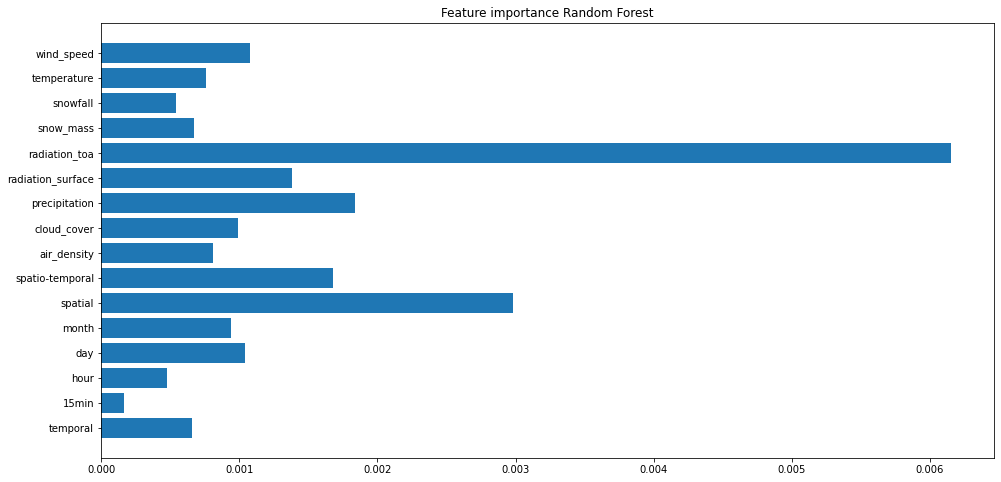

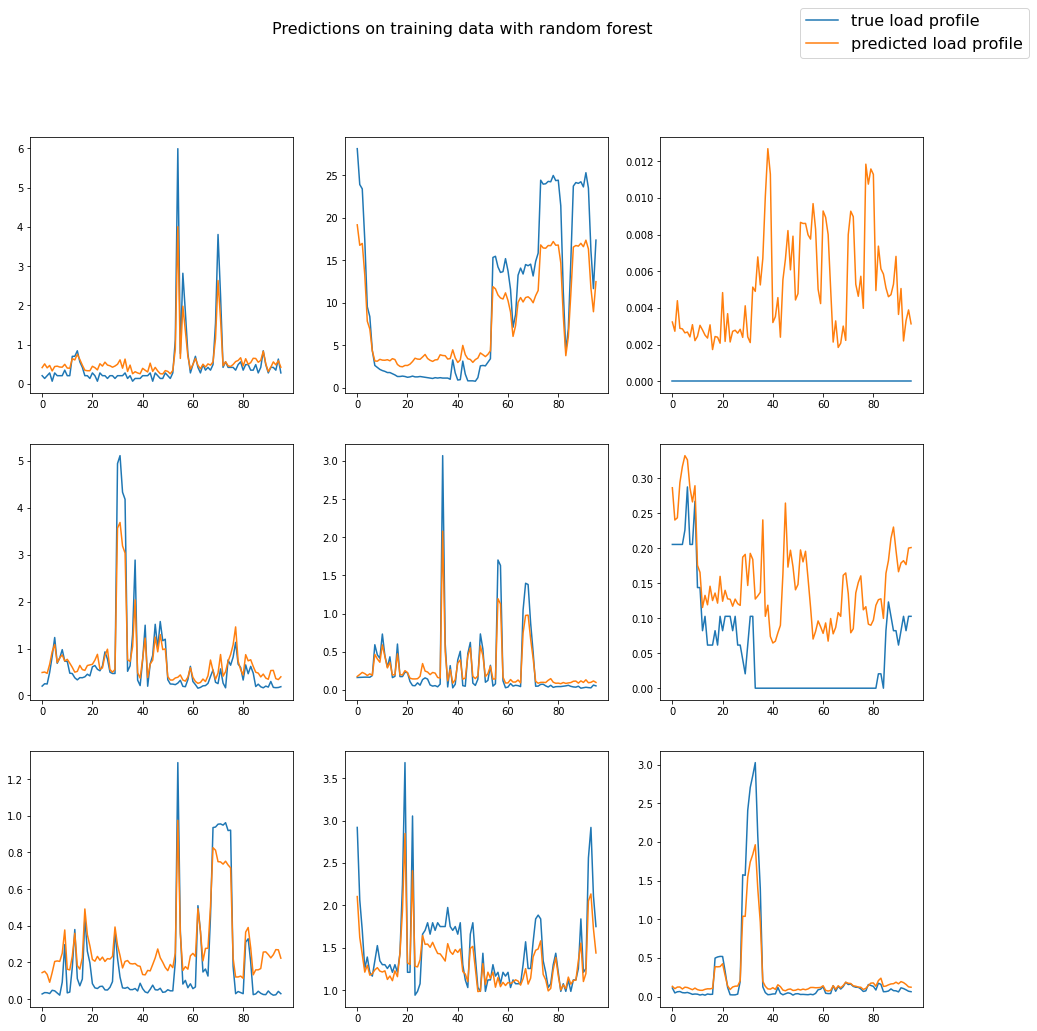

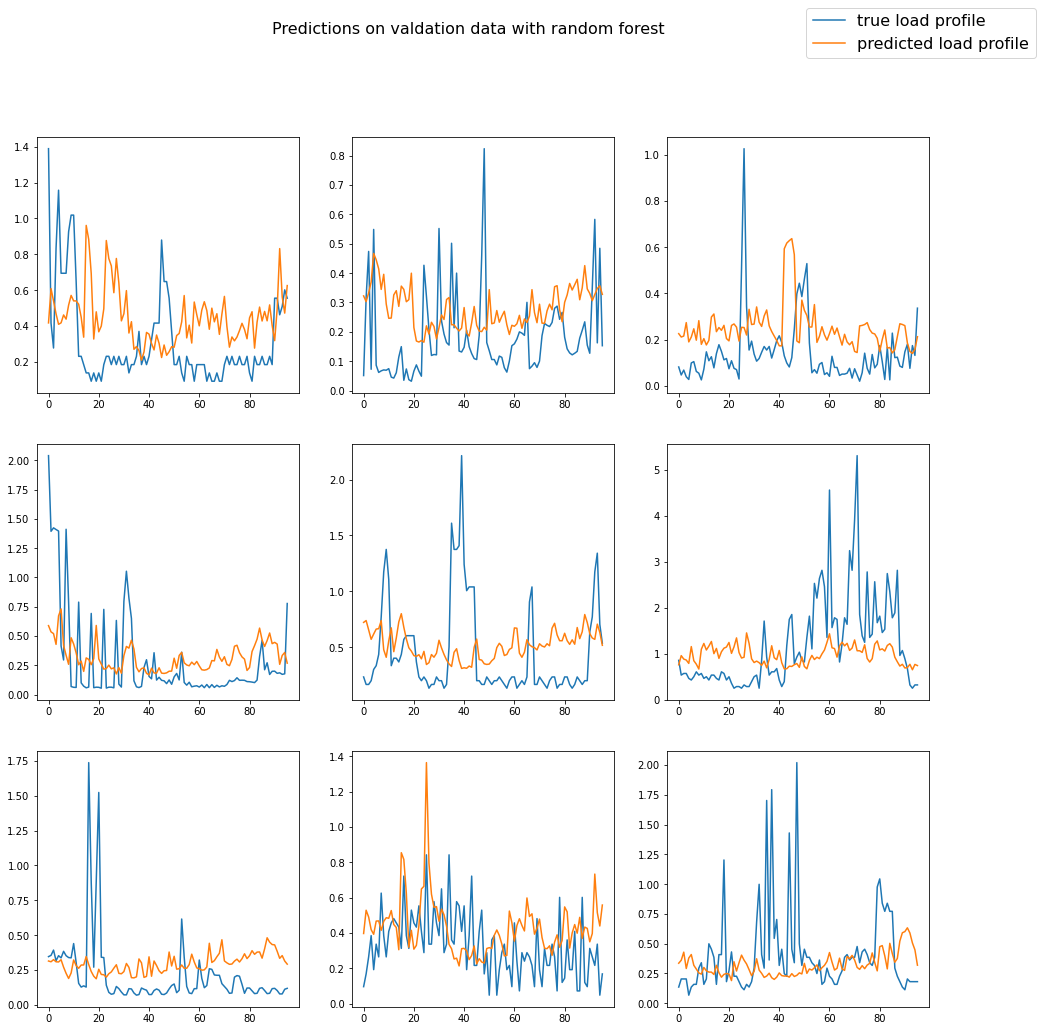

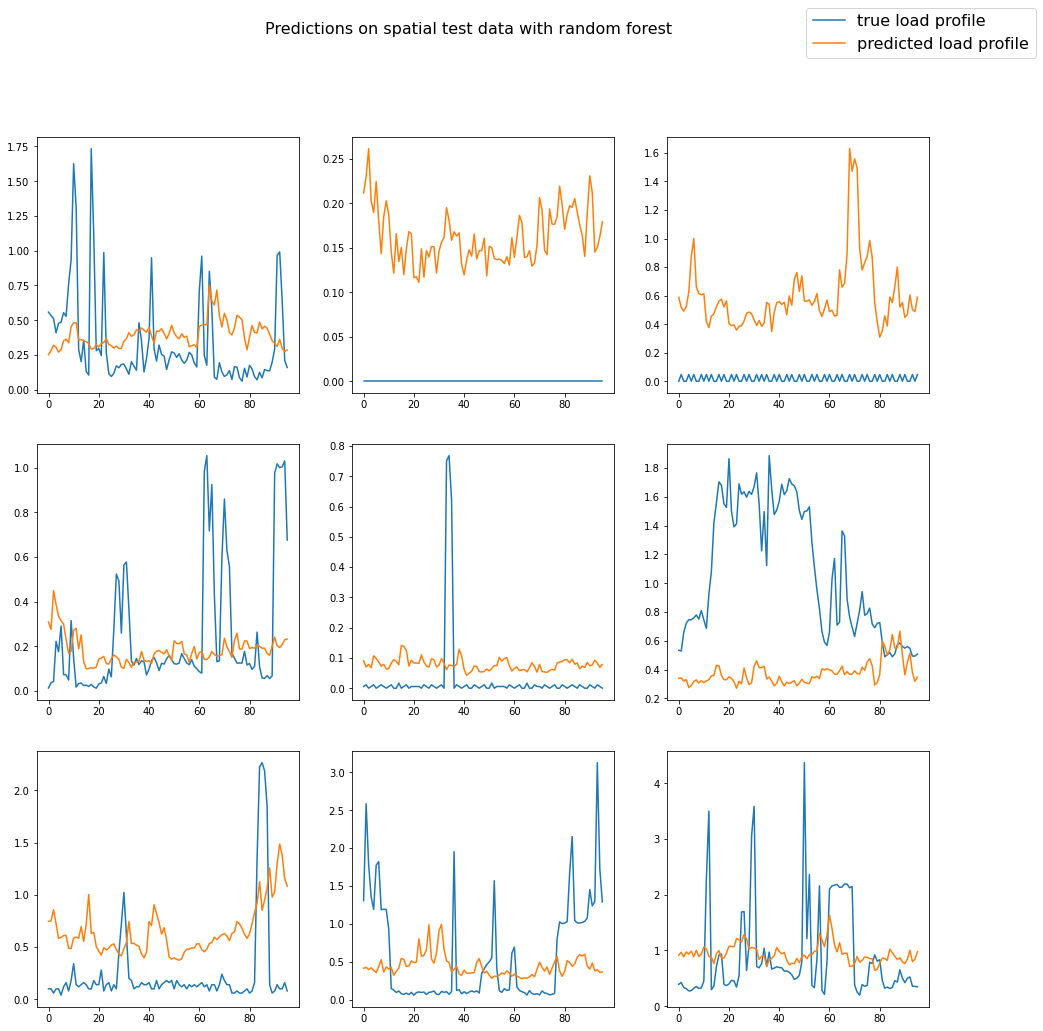

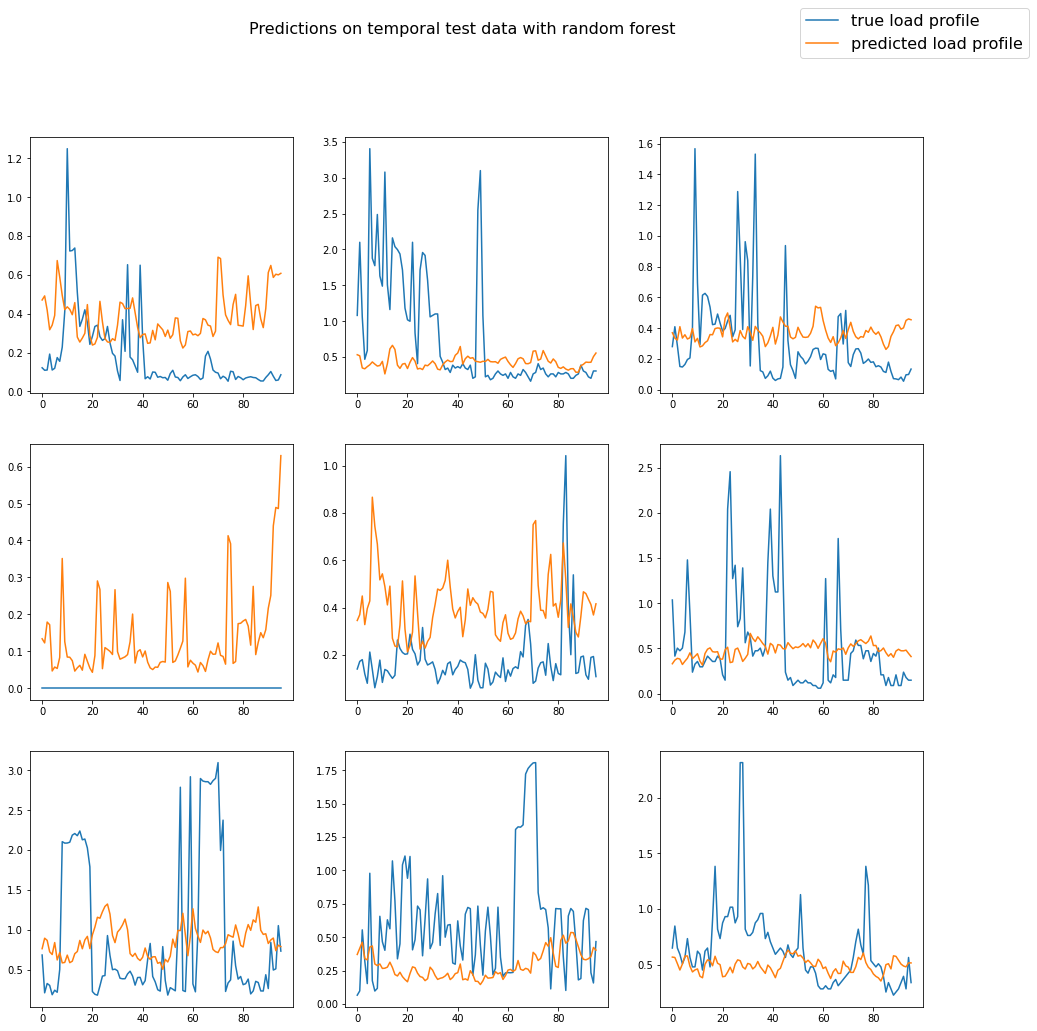

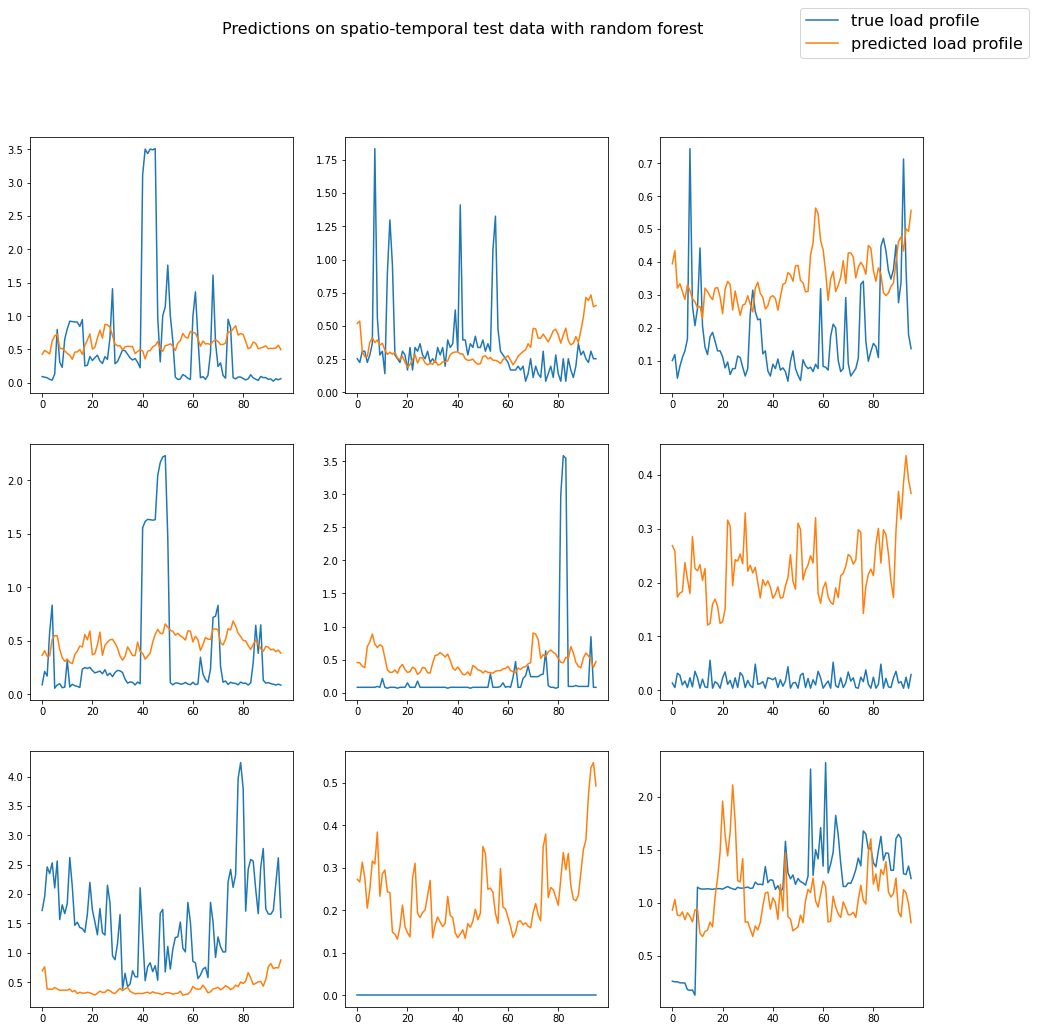

In [12]:
# train a random forest model
RF_regr = prediction.create_and_train_RF(HYPER, training_data)

# make predictions
train_pred = prediction.predict_with_RF(
    HYPER, 
    RF_regr, 
    training_data
)
val_pred = prediction.predict_with_RF(
    HYPER, 
    RF_regr, 
    validation_data
)
spatial_test_pred = prediction.predict_with_RF(
    HYPER, 
    RF_regr, 
    spatial_test_data
)
temporal_test_pred = prediction.predict_with_RF(
    HYPER, 
    RF_regr, 
    temporal_test_data
)
spatemp_test_pred = prediction.predict_with_RF(
    HYPER, 
    RF_regr, 
    spatemp_test_data
) 
    
# Calculate the loss on each prediction
mean_loss.reset_states()
train_l = mean_loss(
    loss_function(
        training_data.Y, 
        train_pred
    )
).numpy()

mean_loss.reset_states()
val_l = mean_loss(
    loss_function(
        validation_data.Y, 
        val_pred
    )
).numpy()

mean_loss.reset_states()
test_l_spatial = mean_loss(
    loss_function(
        spatial_test_data.Y, 
        spatial_test_pred
    )
).numpy()

mean_loss.reset_states()
test_l_temporal = mean_loss(
    loss_function(
        temporal_test_data.Y, 
        temporal_test_pred
    )
).numpy()

mean_loss.reset_states()
test_l_spatemp = mean_loss(
    loss_function(
        spatemp_test_data.Y, 
        spatemp_test_pred
    )
).numpy()

RF_results = {
    'spatial': test_l_spatial, 
    'temporal': test_l_temporal, 
    'spatio-temporal': test_l_spatemp
}
    
# Tell us the out of bag validation score and prediction losses
print(
    'The out-of-bag validation score for random forest is:', 
    RF_regr.oob_score_
)
print(
    'Loss on training data:             {}'.format(
        train_l
    )
)
print(
    'Loss on validation data:           {}'.format(
        val_l
    )
)
print(
    'Loss on spatial test data:         {}'.format(
        test_l_spatial
    )
)
print(
    'Loss on temporal test data:        {}'.format(
        test_l_temporal
    )
)
print(
    'Loss on spatio-temporal test data: {}'.format(
        test_l_spatemp
    )
)


###
# Visualize predictions and feature importance ###
###

# call feature importance plotting function
prediction.plot_RF_feature_importance(
    HYPER, 
    raw_data, 
    RF_regr.feature_importances_, 
    training_data
)

# call prediction comparison plotting function
prediction.plot_true_vs_prediction(
    'Predictions on training data with random forest', 
    training_data.Y, 
    train_pred
)
prediction.plot_true_vs_prediction(
    'Predictions on valdation data with random forest', 
    validation_data.Y, 
    val_pred
)
prediction.plot_true_vs_prediction(
    'Predictions on spatial test data with random forest', 
    spatial_test_data.Y, 
    spatial_test_pred
)
prediction.plot_true_vs_prediction(
    'Predictions on temporal test data with random forest', 
    temporal_test_data.Y, 
    temporal_test_pred
)
prediction.plot_true_vs_prediction(
    'Predictions on spatio-temporal test data with random forest', 
    spatemp_test_data.Y, 
    spatemp_test_pred
)

# delete the model as it occupies a large amount of memory
del RF_regr
_ = gc.collect()

### 2.2 Definition

Here, we build our embedding network prediction model with an architecture that can be set through a number of hyper parameters. The model summary below contains the tensor shapes of each layer of our model, and the number of its trainable weights/parameters. The subsequent computational graphs then show the constellation of each module of our network, which we will refer to as feature encoders, and how the entire prediction model is built from all these modules. 

Building prediction model
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_t (InputLayer)                [(None, 4)]          0                                            
__________________________________________________________________________________________________
X_s1 (InputLayer)               [(None, 100, 3)]     0                                            
__________________________________________________________________________________________________
X_st (InputLayer)               [(None, 24, 9)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1000)         5000        X_t[0][0]                        
__________________________________________________________________

None

Computation graph for X_t_encoder:


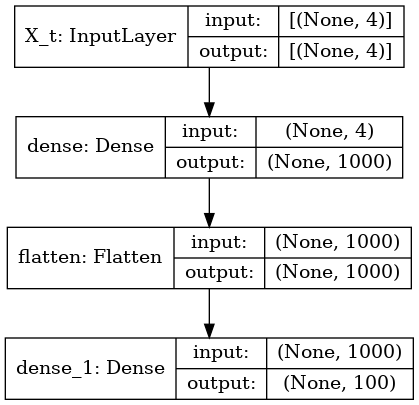

---------------------------------------------------------------------------------------------------------


None

Computation graph for X_s1_encoder:


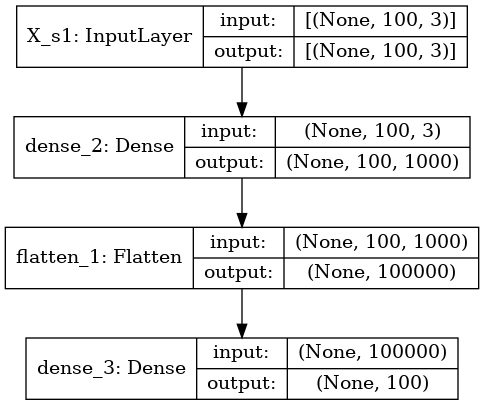

---------------------------------------------------------------------------------------------------------


None

Computation graph for X_st_encoder:


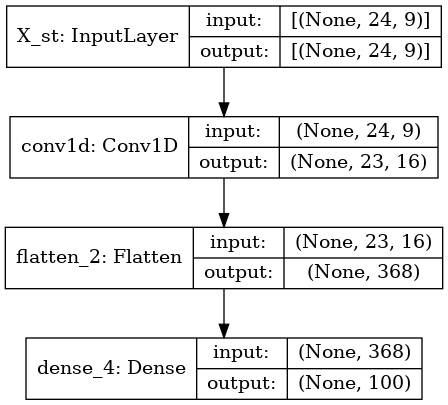

---------------------------------------------------------------------------------------------------------


None

Computation graph for X_joint_encoder:


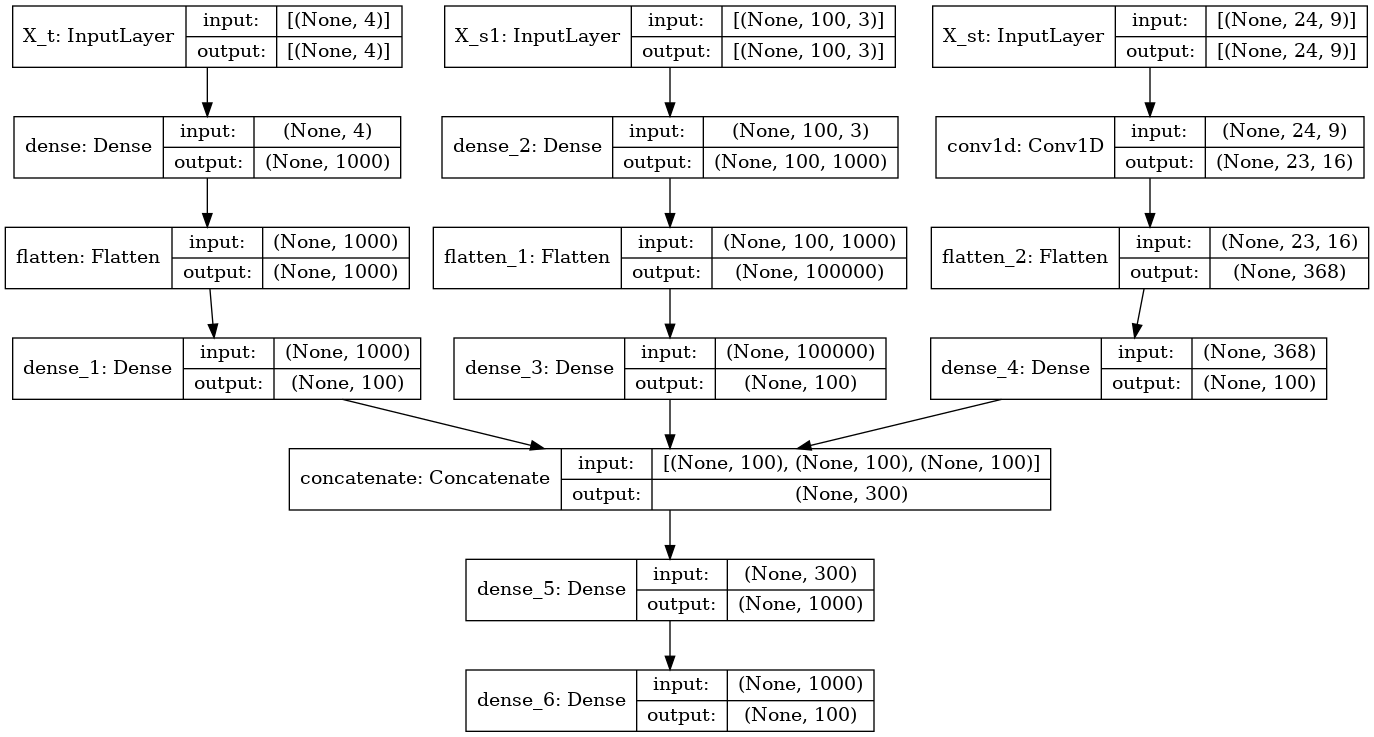

---------------------------------------------------------------------------------------------------------


None

Computation graph for prediction_model:


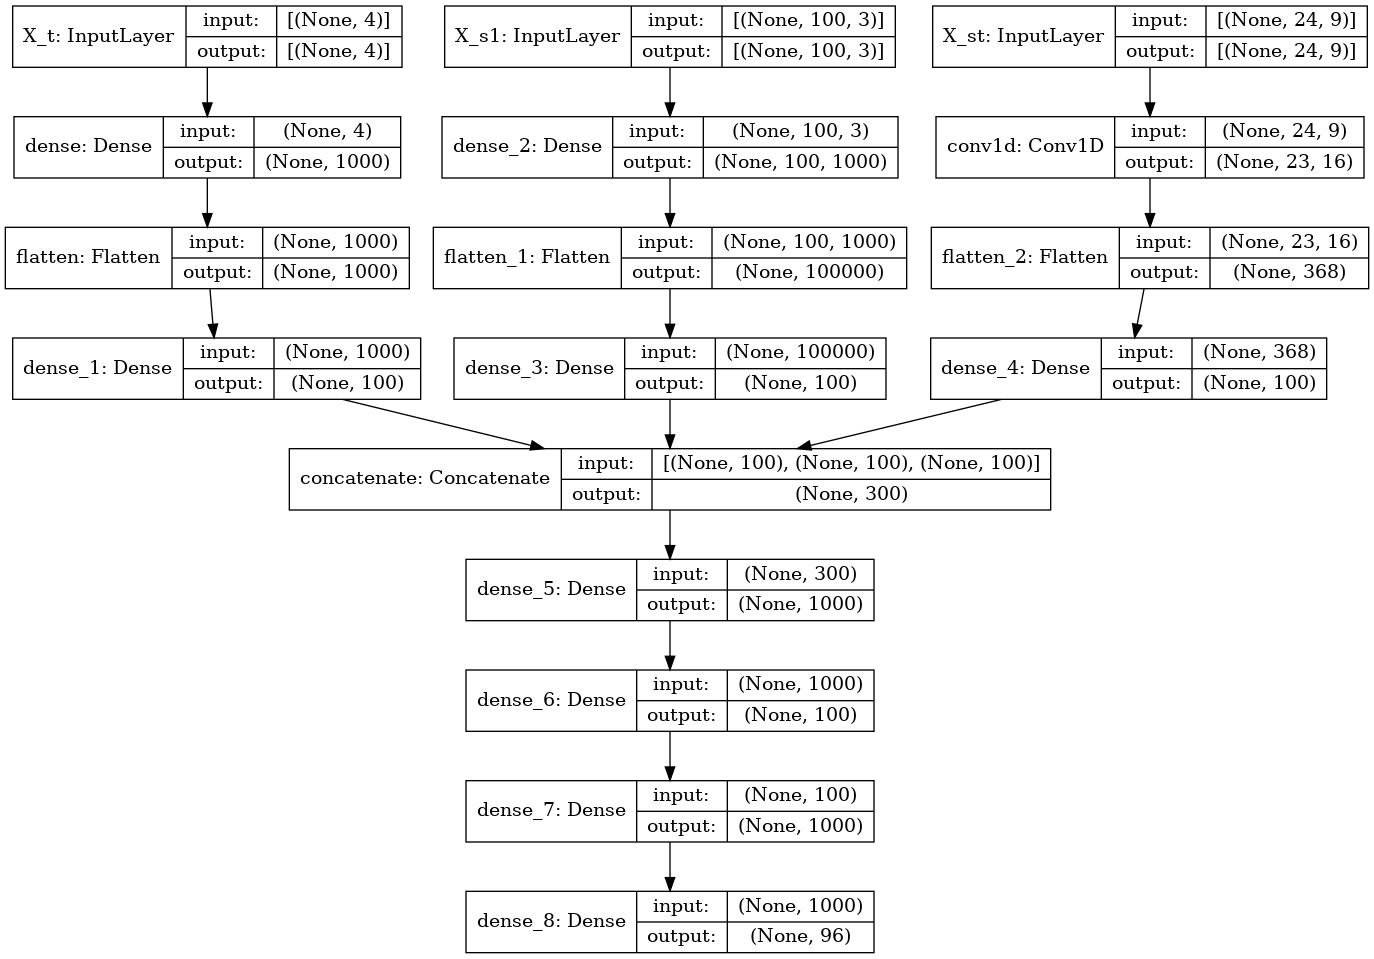

---------------------------------------------------------------------------------------------------------


In [13]:
models = prediction.build_prediction_model(
    HYPER, 
    raw_data, 
    training_data
)

### 2.3 Training

Here, we use our training dataset to learn a functional relationship between our features on the one side and our labels on the other side. We use the functional API of the tensorflow deep learning framework to do this. The plot below illustrates the training and validation loss history (y-axis) for each epoch of training (x-axis). An epoch stands for an entire iteration over the available (randomly sequenced) training dataset.

Note: All details of the training process can be seen in the src/**hyperparameters.py** file where we set hyper parameters. 

Epoch 1/30
Training:
70/69 [==============================] - 4s 5ms/step - loss: 0.8681
Validation:
70/69 [==============================] - 0s 2ms/step - loss: 0.9392
Epoch 2/30
Training:
70/69 [==============================] - 0s 4ms/step - loss: 0.8193
Validation:
70/69 [==============================] - 0s 2ms/step - loss: 0.8927
Epoch 3/30
Training:
70/69 [==============================] - 0s 4ms/step - loss: 0.7624
Validation:
70/69 [==============================] - 0s 2ms/step - loss: 0.7412
Epoch 4/30
Training:
70/69 [==============================] - 0s 4ms/step - loss: 0.7705
Validation:
70/69 [==============================] - 0s 2ms/step - loss: 0.7529
Epoch 5/30
Training:
70/69 [==============================] - 0s 4ms/step - loss: 0.7575
Validation:
70/69 [==============================] - 0s 2ms/step - loss: 0.8444
Epoch 6/30
Training:
70/69 [==============================] - 0s 4ms/step - loss: 0.7228
Validation:
70/69 [==============================] - 0s 2ms/step -

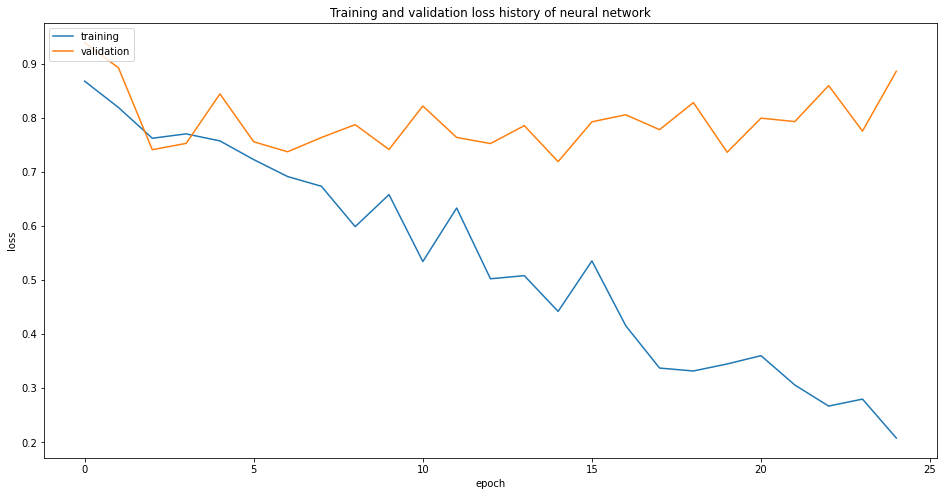

In [14]:
# Call training and saving functions
train_loss_hist, val_loss_hist = prediction.train_model(
    HYPER, 
    models.prediction_model, 
    training_data, 
    validation_data, 
    raw_data,
    loss_object, 
    optimizer, 
    mean_loss,
    plot=True,
    silent=False
)
prediction.save_prediction_model(
    HYPER, 
    raw_data, 
    models.prediction_model, 
    'initial'
)
prediction.save_encoder_and_predictor_weights(
    HYPER, 
    raw_data, 
    models
)

### 2.4 Testing

We calculate the prediction error of our trained model on all available datasets and plot exemplar predictons for each of these. The x-axis of each plot describes the 15-min time steps into the future from a given time stamp, and the y-axis the corresponding electric consumption of a given building at these times in kW/kWh.

Note: Again, the evaluation of the training and validation datasets merely serve for a comparision to our random forest baseline predictor and for seeing whether we are able to learn useful patterns, underfit or overfit. 

Training data loss: 0.2725589


/DataSelectionMaps/src/prediction.py:277: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize=16,


Validation data loss: 0.8836243


/DataSelectionMaps/src/prediction.py:277: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize=16,


Spatial test data loss: 1.8828346


/DataSelectionMaps/src/prediction.py:277: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize=16,


Temporal test data loss: 1183.1611


/DataSelectionMaps/src/prediction.py:277: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize=16,


Spatio temporal test data loss: 1234.3914


/DataSelectionMaps/src/prediction.py:277: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize=16,


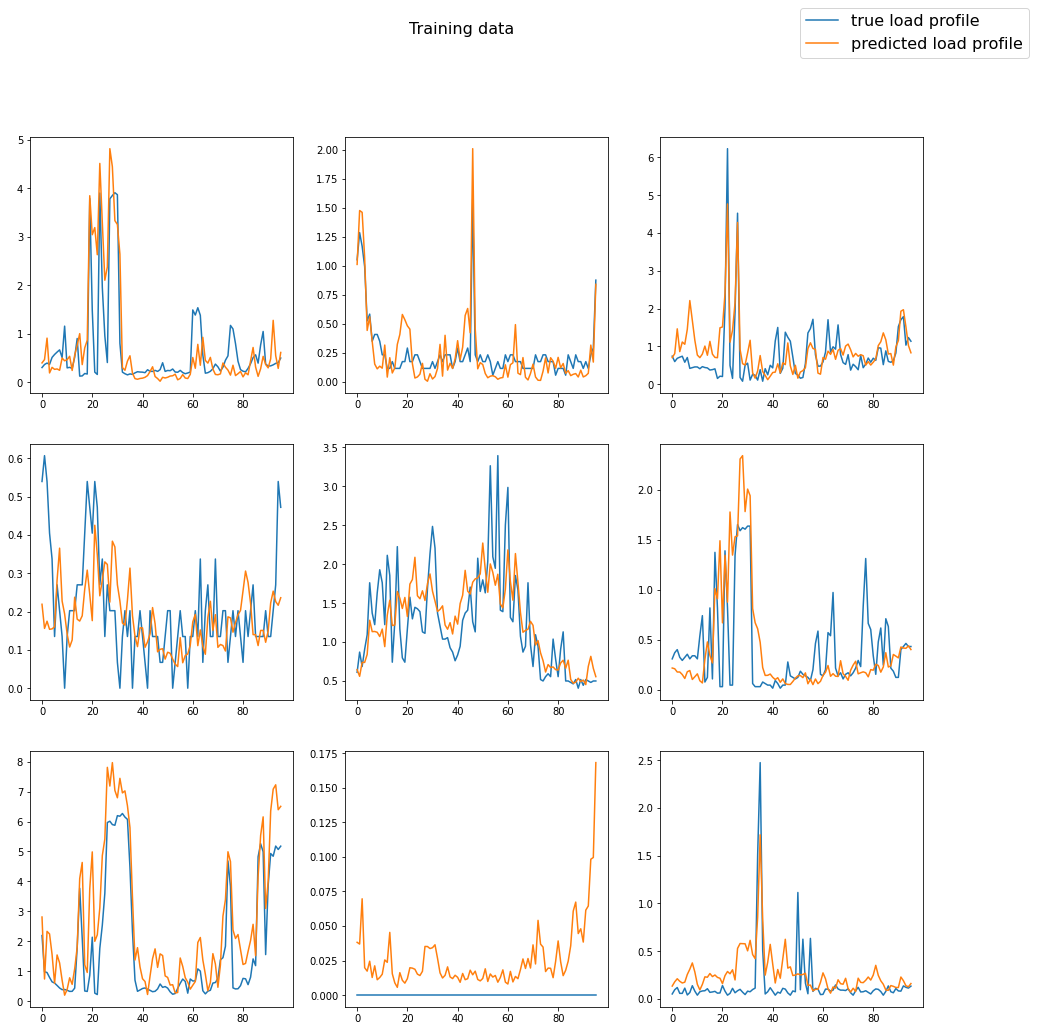

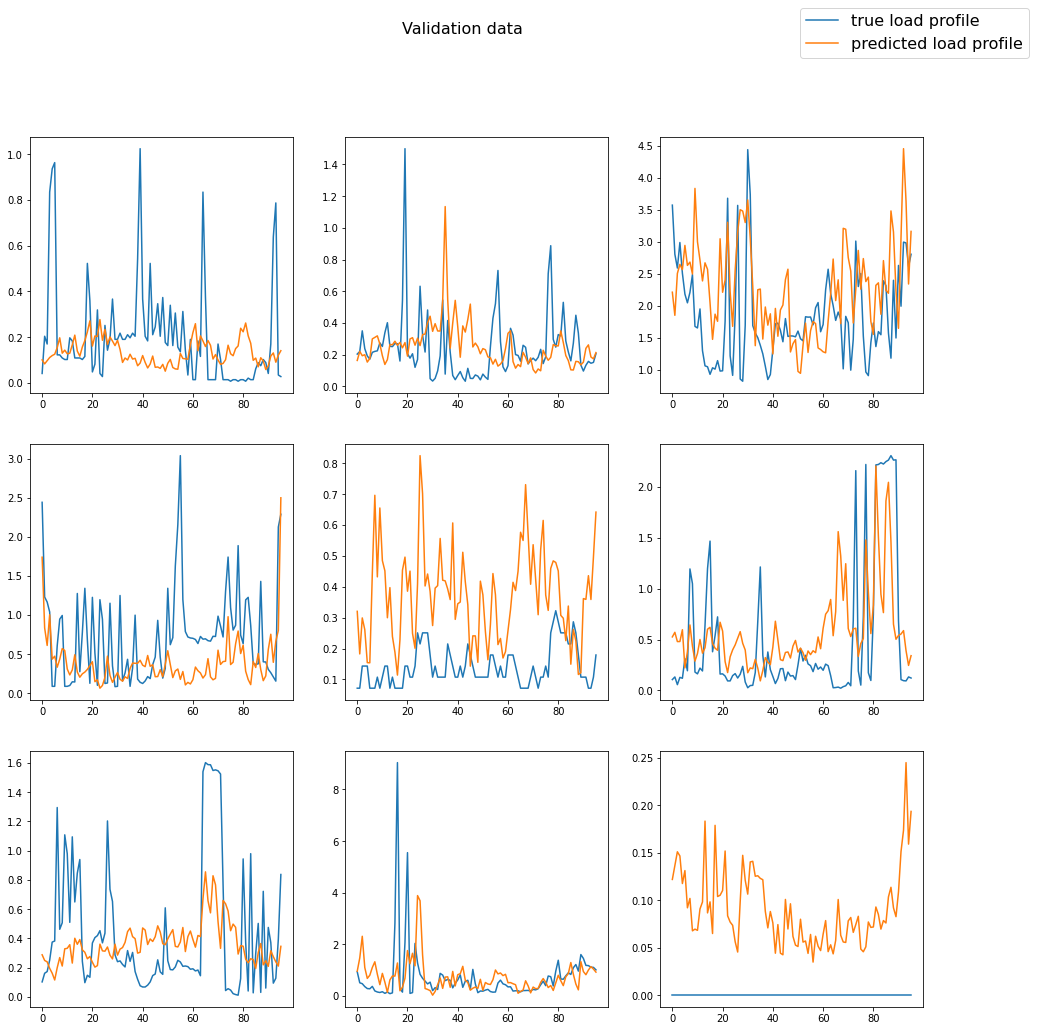

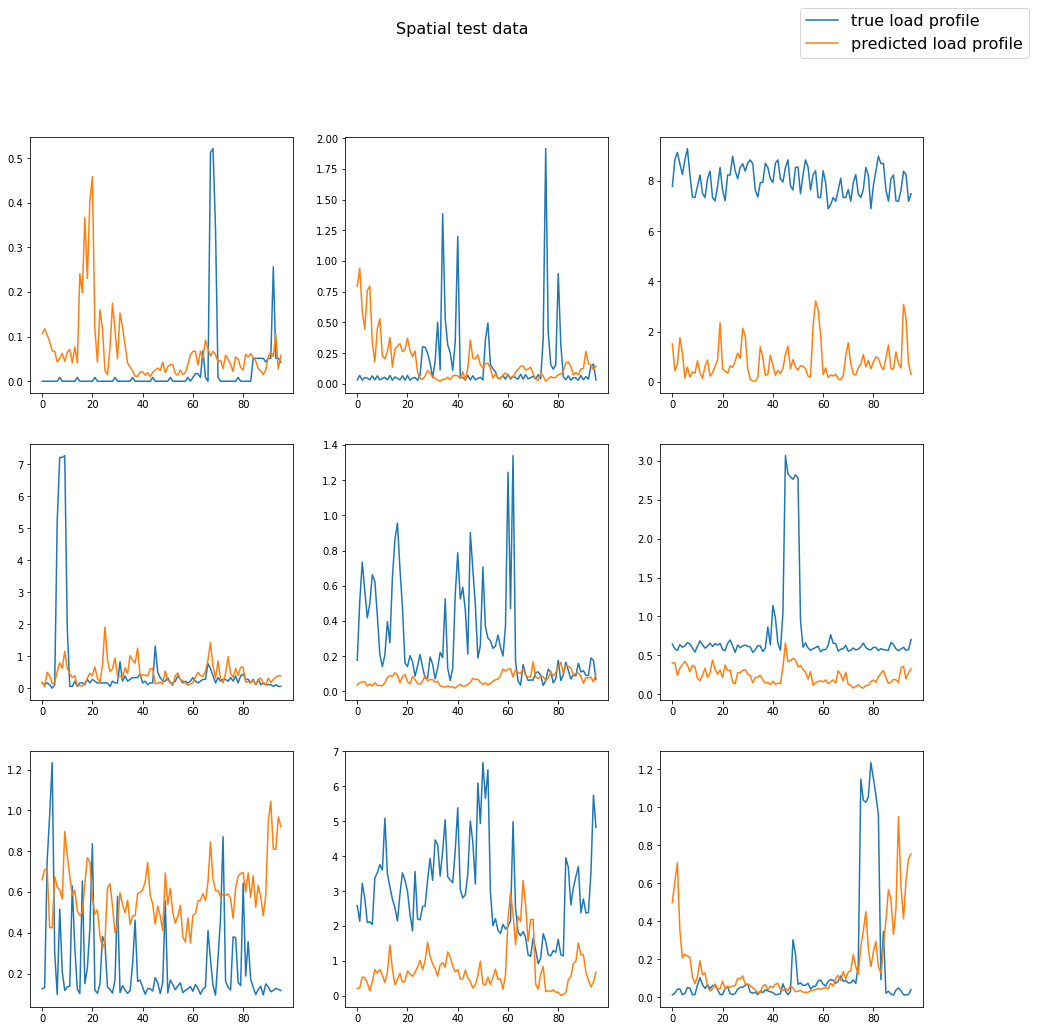

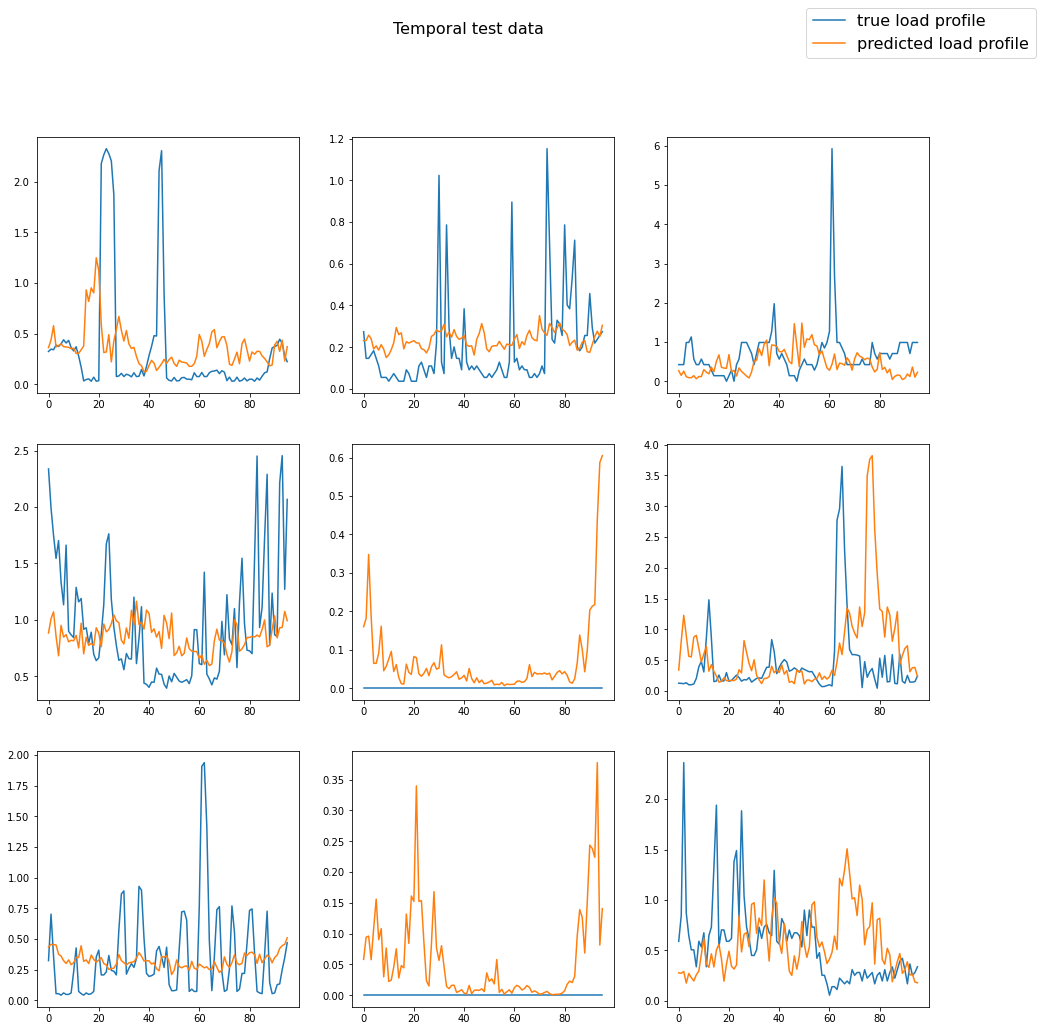

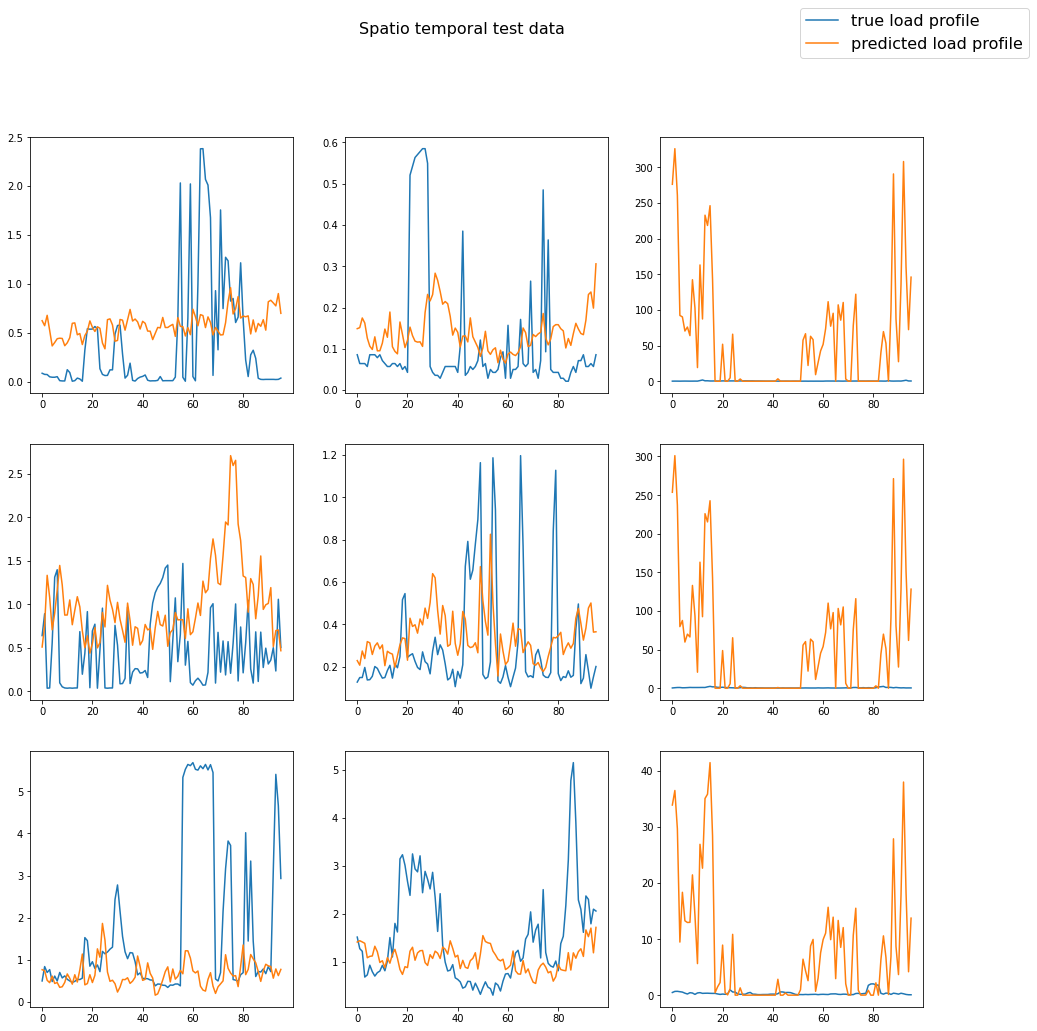

In [15]:
prediction.test_model(
    HYPER, 
    'Training data', 
    models.prediction_model, 
    training_data, 
    raw_data,
    mean_loss, 
    loss_function, 
    silent=False, 
    plot=True
)
prediction.test_model(
    HYPER, 
    'Validation data', 
    models.prediction_model, 
    validation_data, 
    raw_data,
    mean_loss, 
    loss_function, 
    silent=False, 
    plot=True
)
prediction.test_model(
    HYPER, 
    'Spatial test data', 
    models.prediction_model, 
    spatial_test_data, 
    raw_data,
    mean_loss, 
    loss_function, 
    silent=False, 
    plot=True
)
prediction.test_model(
    HYPER, 
    'Temporal test data', 
    models.prediction_model, 
    temporal_test_data, 
    raw_data,
    mean_loss,  
    loss_function, 
    silent=False, 
    plot=True
)
_ = prediction.test_model(
    HYPER, 
    'Spatio temporal test data', 
    models.prediction_model, 
    spatemp_test_data, 
    raw_data,
    mean_loss, 
    loss_function, 
    silent=False, 
    plot=True
)

## 3. Active learning

In this section, we develop our pool-based batch active learning method. First, we encode the features of candidate data points into an embedded vector space using an embedding network that is trained on initially available data points. In this case, the initially available data is our training dataset. Second, we cluster candidate data points based on their vector distances to each other in the encoded space. Candidate data points whose embedded feature vectors are further away from their cluster centers are assumed to be more diverse than other members of their cluster and therefore have a larger embedding entropy. Candidate data points whose embedded feature vectors are closer to their cluster centers are assumed to be better core-set representatives of the underlying data, having smaller embedding entropy. We start with creating a new class object *ActLrnResults* which bundles all the results for each of the active learning variants that we evaluate. Classes and functions that we introduce in this section are defined in **activelearning.py**.

In [16]:
# initialize hyper parameters for AL
HYPER.set_act_lrn_params()

dataset_list = [
    spatial_test_data, 
    temporal_test_data, 
    spatemp_test_data
]

# for demonstration, consider all possible query variables
query_variable_list = [
    'X_t', 
    'X_s1', 
    'X_st', 
    'X_(t,s)', 
    'Y_hat_(t,s)', 
    'Y_(t,s)'
]

### 3.1 Encode features

We use the encoders that were previously trained alongside our prediction model to encode features into an embedded vector space. Each feature type (time, space, space-time variant) has its own encoder. All features together further have a joint encoder that can encode the respective feature vectors of each data point into an embedded vector space of some fixed dimension. The vector space into which each feature vector is embedded is defined through the last layer (embedding layer) of each encoder that we define through the architecture of our embedding network prediction model. 

In [17]:
# create empty lists for saving encoded features
encoded_dataset_list = []

for dataset in dataset_list:

    available_index_set = set(
        np.arange(
            dataset.n_datapoints
        )
    )
    
    encoding_list = []
    
    for query_variable in query_variable_list:

        encoding, _ = activelearning.encode_features(
            HYPER, 
            raw_data, 
            models, 
            dataset,
            available_index_set,
            query_variable, 
            silent=False
        )
        
        encoding_list.append(encoding)
        
    encoded_dataset_list.append(encoding_list)

Encoding features into embedded vector spaces for X_t
Encoding features into embedded vector spaces for X_s1
Encoding features into embedded vector spaces for X_st
Encoding features into embedded vector spaces for X_(t,s)
Encoding features into embedded vector spaces for Y_hat_(t,s)
Encoding features into embedded vector spaces for Y_(t,s)
Encoding features into embedded vector spaces for X_t
Encoding features into embedded vector spaces for X_s1
Encoding features into embedded vector spaces for X_st
Encoding features into embedded vector spaces for X_(t,s)
Encoding features into embedded vector spaces for Y_hat_(t,s)
Encoding features into embedded vector spaces for Y_(t,s)
Encoding features into embedded vector spaces for X_t
Encoding features into embedded vector spaces for X_s1
Encoding features into embedded vector spaces for X_st
Encoding features into embedded vector spaces for X_(t,s)
Encoding features into embedded vector spaces for Y_hat_(t,s)
Encoding features into embedded 

### 3.2 Compute clusters

In each encoded vector space, we can use the distances of encoded feature vectors to each other to compute clusters in our embedded data. The method that we use for clustering data points can be set through our hyper parameters which is the K-means++ algorithm here. 

In [18]:
# create empty lists for saving results
labels_list = []
centers_list = []

for dataset, encoded_dataset in zip(
    dataset_list, 
    encoded_dataset_list
):

    l_list = []
    c_list = []

    for encoding in encoded_dataset:
        
        # Compute total data budget
        data_budget = math.floor(
            HYPER.DATA_BUDGET_ACT_LRN * dataset.n_datapoints
        )

        # compute the batch siz of this iteration
        cand_batch_size = int(
            HYPER.CAND_BATCH_SIZE_ACT_LRN * data_budget
        )
        
        # if exceeding candidate data subsample, adjust batch size
        if HYPER.CAND_SUBSAMPLE_ACT_LRN is not None:

            cand_batch_size = min(
                cand_batch_size, 
                HYPER.CAND_SUBSAMPLE_ACT_LRN
            )

        # create clusters
        labels, centers, n_clusters = activelearning.compute_clusters(
            HYPER, 
            encoding, 
            cand_batch_size, 
            silent=False
        )
        
        # add to lists
        l_list.append(labels)
        c_list.append(centers)
        
    labels_list.append(l_list)
    centers_list.append(c_list)

Creating clusters in encodings with n_clusters= 113


/DataSelectionMaps/src/activelearning.py:258: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (113). Possibly due to duplicate points in X.
  clustering_method.fit(encoding)


Creating clusters in encodings with n_clusters= 113
Creating clusters in encodings with n_clusters= 113
Creating clusters in encodings with n_clusters= 113
Creating clusters in encodings with n_clusters= 113
Creating clusters in encodings with n_clusters= 113
Creating clusters in encodings with n_clusters= 112


/DataSelectionMaps/src/activelearning.py:258: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (112). Possibly due to duplicate points in X.
  clustering_method.fit(encoding)


Creating clusters in encodings with n_clusters= 112
Creating clusters in encodings with n_clusters= 112
Creating clusters in encodings with n_clusters= 112
Creating clusters in encodings with n_clusters= 112
Creating clusters in encodings with n_clusters= 112
Creating clusters in encodings with n_clusters= 113


/DataSelectionMaps/src/activelearning.py:258: ConvergenceWarning: Number of distinct clusters (20) found smaller than n_clusters (113). Possibly due to duplicate points in X.
  clustering_method.fit(encoding)


Creating clusters in encodings with n_clusters= 113
Creating clusters in encodings with n_clusters= 113
Creating clusters in encodings with n_clusters= 113
Creating clusters in encodings with n_clusters= 113
Creating clusters in encodings with n_clusters= 113


### 3.3 Compute distances

We can use the distance of each embedded data point (or its partial feature vectors) to its cluster's center to express our metric of informativeness, i,e. the embedding entropy of each candidate data point.

In [19]:
for index_dataset, encoded_dataset in enumerate(encoded_dataset_list):

    l_list = labels_list[index_dataset]
    c_list = centers_list[index_dataset]

    for index_var in range(len(query_variable_list)):
        
        encoding = encoded_dataset[index_var]
        cluster_labels = l_list[index_var]
        cluster_centers = c_list[index_var]
        similarity_array =  activelearning.compute_similarity(
            HYPER, 
            encoding, 
            cluster_labels, 
            cluster_centers, 
            silent=False
        )

Calculating distances
2260/2260 [==============================] - 0s 217us/step
Calculating distances
2260/2260 [==============================] - 0s 206us/step
Calculating distances
2260/2260 [==============================] - 0s 207us/step
Calculating distances
2260/2260 [==============================] - 0s 207us/step
Calculating distances
2260/2260 [==============================] - 0s 206us/step
Calculating distances
2260/2260 [==============================] - 0s 205us/step
Calculating distances
2250/2250 [==============================] - 0s 203us/step
Calculating distances
2250/2250 [==============================] - 0s 205us/step
Calculating distances
2250/2250 [==============================] - 0s 204us/step
Calculating distances
2250/2250 [==============================] - 0s 202us/step
Calculating distances
2250/2250 [==============================] - 0s 202us/step
Calculating distances
2250/2250 [==============================] - 0s 202us/step
Calculating distances
2260/2

### 3.4 Batching algorithm

In each iteration of our active learning algorithm, we query a batch of data points. We evaluate the performance of our algorithm for each prediction type and compare these to a passive learning benchmark. For each prediction type, we evaluate data queries according to the embedding entropy of our respective feature vectors. We also evaluate the performance of our algorithm for the hypothetical case of using the true labels of candidates as query variable, representing the optimal priors that we can build. The outputs below show information about the progress of a set of relevant values of our algorithm in each iteration. Furthermore, if chosen so through hyper parameters, we conduct another set of experiments in which we randomize the sequence of actively queried data points to see whether purely the information content of queried data matters, or whether the training sequence of queried data also has an impact on training and validation losses.

Note: We plot our random forest baseline prediction losses (dashed red line) to see whether our models make reasonably good predictions or not.

prediction task:             spatial
AL variable:              None
AL variant:               PL
distance metric:             Laplacian
clustering method:           KMeans
data budget:                 1130/2260 (50%)
used sensors:                225
new sensors to place:        226
used streaming times:        10
new streaming times to use:  0
---------
Iteration:                            1
Time:                                 4s
Trained on candidate batch size:      113
Used streaming times:                 0/0 (0%)
Used sensors:                         88/226 (39%)
Used data budget:                     113/1130 (10%)
---------
Iteration:                            2
Time:                                 3s
Trained on candidate batch size:      113
Used streaming times:                 0/0 (0%)
Used sensors:                         145/226 (64%)
Used data budget:                     226/1130 (20%)
---------
Iteration:                            3
Time:                              

Iteration:                            6
Time:                                 20s
Trained on candidate batch size:      113
Used streaming times:                 0/0 (0%)
Used sensors:                         149/226 (66%)
Used data budget:                     678/1130 (60%)
---------
Iteration:                            7
Time:                                 15s
Trained on candidate batch size:      113
Used streaming times:                 0/0 (0%)
Used sensors:                         158/226 (70%)
Used data budget:                     791/1130 (70%)
---------
Iteration:                            8
Time:                                 16s
Trained on candidate batch size:      113
Used streaming times:                 0/0 (0%)
Used sensors:                         172/226 (76%)
Used data budget:                     904/1130 (80%)
---------
Iteration:                            9
Time:                                 15s
Trained on candidate batch size:      113
Used streaming tim

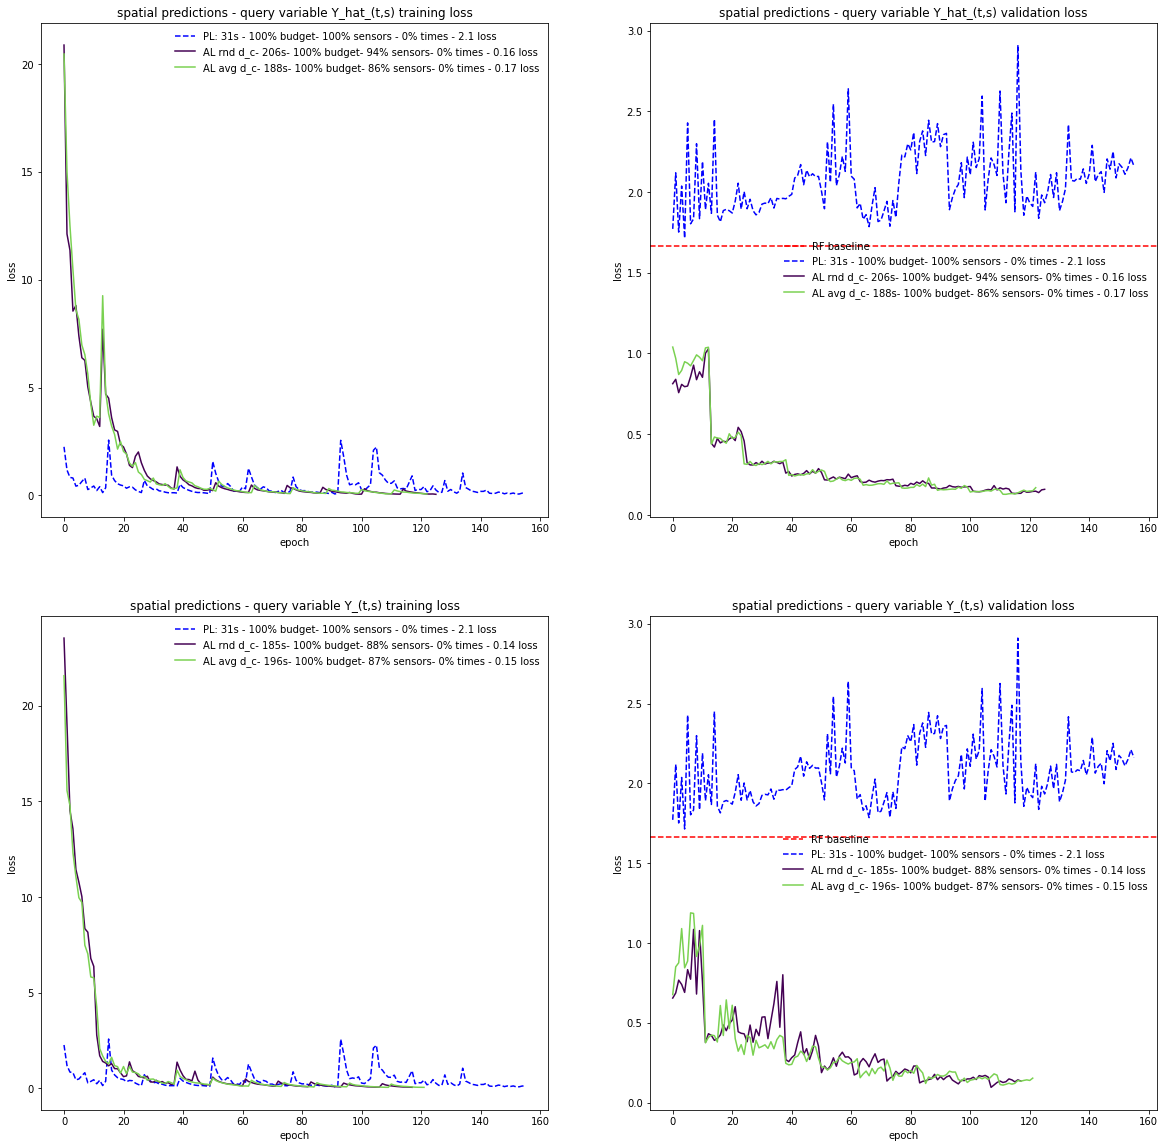

In [20]:
# initialize hyper parameters for AL
HYPER.set_act_lrn_params()

# create empty lists to add results
AL_result_list = []
PL_result_list = []

# iterate over all prediction types
for pred_type in HYPER.PRED_LIST_ACT_LRN:
    
    # choose corresponding test data of currently iterated pred_type
    if pred_type=='spatial':
        dataset = dataset_list[0]
        
    if pred_type=='temporal':
        dataset = dataset_list[1]
        
    if pred_type=='spatio-temporal':
        dataset = dataset_list[2]
        
    # create random result for benchmark once only for this pred_type
    PL_result =  activelearning.feature_embedding_AL(
        HYPER, 
        pred_type, 
        models, 
        raw_data, 
        training_data, 
        dataset, 
        loss_object, 
        optimizer, 
        mean_loss,  
        loss_function,
        'PL', 
        silent=False
    )
    
    # create empty list for saving results of corresponding AL variable
    var_result_list = []

    # iterate over all sort variables that are chosen to be considered
    for query_variable in HYPER.QUERY_VARIABLES_ACT_LRN:
    
        # empty list for savings results of correspnding AL variant
        method_result_list = []

        # iterate over all methods that are chosen to be considered
        for method in HYPER.QUERY_VARIANTS_ACT_LRN:

            # test AL with currently iterated AL variable and variant
            AL_result =  activelearning.feature_embedding_AL(
                HYPER, 
                pred_type, 
                models, 
                raw_data, 
                training_data, 
                dataset,
                loss_object, 
                optimizer, 
                mean_loss,  
                loss_function,
                method=method, 
                AL_variable=query_variable, 
                silent=False
            )
            
            # test sequence importance for iterated AL variable and variant
            AL_result = activelearning.test_AL_sequence_importance(
                HYPER, 
                pred_type, 
                models, 
                raw_data, 
                training_data, 
                dataset, 
                loss_object, 
                optimizer, 
                mean_loss,  
                loss_function, 
                AL_result,
                method=method, 
                AL_variable=query_variable, 
                silent=False
            )

            # add results to method_result_list
            method_result_list.append(AL_result)
         
         # add results to var_result_list
        var_result_list.append(method_result_list)
    
    # add results to total result_list and random_result_list
    AL_result_list.append(var_result_list)
    PL_result_list.append(PL_result)
    
# call visualization function for comparing train and validation results
activelearning.vis_train_and_val(
    HYPER, 
    AL_result_list, 
    PL_result_list, 
    RF_results
)

# call visualization function for comparing losses for random vs AL query sequence
activelearning.vis_seq_importance(
    HYPER, 
    AL_result_list
)

# save active learning results
activelearning.save_act_lrn_results(
    HYPER, 
    raw_data, 
    RF_results, 
    AL_result_list, 
    PL_result_list
)

# save hyper parameters
activelearning.save_hyper_params(
    HYPER, 
    raw_data
)

# save the prediction models
activelearning.save_act_lrn_models(
    HYPER, 
    raw_data, 
    AL_result_list, 
    PL_result_list
)

# save the test data sample
activelearning.save_act_lrn_test_sample(
    HYPER, 
    raw_data, 
    AL_result_list, 
    PL_result_list
)